In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pathlib import Path




In [11]:
TICKERS = ["TSLA", "BND", "SPY"]
START = "2015-07-01"
END = "2025-07-31"
RAW_DIR = Path("../data/raw")

In [ ]:


def download_and_save(ticker, start=START, end=END, raw_dir=RAW_DIR, max_retries=3, pause=1.0):
    """
    Download daily OHLCV from yfinance and save CSV to data/raw/<ticker>.csv
    Returns the dataframe.
    """
    attempts = 0
    while attempts < max_retries:
        try:
            df = yf.download(ticker, start=start, end=end, progress=False, threads=True, auto_adjust=False)
            if df.empty:
                raise ValueError(f"No data returned for {ticker}.")
            df.index.name = "Date"
            # Save raw CSV
            filepath = raw_dir / f"{ticker}.csv"
            df.to_csv(filepath)
            print(f"Saved {ticker} to {filepath} (rows: {len(df)})")
            return df
        except Exception as e:
            attempts += 1
            print(f"Attempt {attempts}/{max_retries} failed for {ticker}: {e}")
            time.sleep(pause)
    raise RuntimeError(f"Failed to download {ticker} after {max_retries} attempts.")

# Example usage (do not run here — run in next cell to fetch all tickers)
# df_tsla = download_and_save("TSLA")

In [4]:
df2 = pd.read_csv(RAW_DIR / "TSLA.csv")
df2.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,01/07/2015,17.943333,17.943333,18.174667,17.856667,18.073999,31518000
1,02/07/2015,18.667999,18.667999,18.830000,18.220667,18.680000,107458500
2,06/07/2015,18.648001,18.648001,18.779333,18.420000,18.591999,61828500
3,07/07/2015,17.858667,17.858667,18.346666,17.384666,18.333332,91576500
4,08/07/2015,16.997334,16.997334,17.386667,16.954000,17.288000,93316500


In [6]:
data = {}
for t in TICKERS:
    df = download_and_save(t)
    data[t] = df
    # quick summary
    first_date = df.index.min()
    last_date = df.index.max()
    print(f"{t}: {first_date.date()} to {last_date.date()}, rows={len(df)}")


Saved TSLA to ..\data\raw\TSLA.csv (rows: 2535)
TSLA: 2015-07-01 to 2025-07-30, rows=2535
Saved BND to ..\data\raw\BND.csv (rows: 2535)
BND: 2015-07-01 to 2025-07-30, rows=2535
Saved SPY to ..\data\raw\SPY.csv (rows: 2535)
SPY: 2015-07-01 to 2025-07-30, rows=2535


In [12]:

# for t in TICKERS:
#     path = RAW_DIR / f"{t}.csv"
#     if not path.exists():
#         print(f"Missing file: {path}")
#         continue
#     df = pd.read_csv(path, parse_dates=["Date"], index_col="Date")
#     print(f"\n--- {t} ---")
#     print(df.info())
#     # Missing values per column
#     print("Missing values:\n", df.isna().sum())
#     # Check continuous trading range gaps: look at max gap between consecutive index days
#     idx = df.index.sort_values()
#     if len(idx) > 1:
#         gaps = (idx[1:] - idx[:-1]).to_series().dt.days
#         max_gap = gaps.max()
#         print("Max gap between rows (days):", max_gap)
#     else:
#         print("Not enough rows to check gaps.")



for t in TICKERS:
    path = RAW_DIR / f"{t}.csv"
    if not path.exists():
        print(f"Missing file: {path}")
        continue

    # Read CSV, force 'Date' as datetime, and convert other columns to numeric
    df = pd.read_csv(path, parse_dates=["Date"], index_col="Date")

    # Remove rows where the index might be non-date (like 'Ticker' row)
    df = df[df.index.to_series().apply(lambda x: isinstance(x, pd.Timestamp))]

    # Convert all columns to numeric where possible
    df = df.apply(pd.to_numeric, errors="coerce")

    print(f"\n--- {t} ---")
    print(df.info())

    # Missing values per column
    print("Missing values:\n", df.isna().sum())

    # Check continuous trading range gaps
    idx = df.index.sort_values()
    if len(idx) > 1:
        gaps = (idx[1:] - idx[:-1]).to_series().dt.days
        max_gap = gaps.max()
        print("Max gap between rows (days):", max_gap)
    else:
        print("Not enough rows to check gaps.")




--- TSLA ---
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  0 non-null      float64
 1   Close      0 non-null      float64
 2   High       0 non-null      float64
 3   Low        0 non-null      float64
 4   Open       0 non-null      float64
 5   Volume     0 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 0.0+ bytes
None
Missing values:
 Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64
Not enough rows to check gaps.

--- BND ---
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  0 non-null      float64
 1   Close      0 non-null      float64
 2   High       0 non-null      float64
 3   Low        0 non-null      float64
 4   Open       0 non-null   

In [14]:
# Build prices (Adj Close) DataFrame
adj_close = {}
for t in TICKERS:
    df = pd.read_csv(RAW_DIR / f"{t}.csv", parse_dates=["Date"], index_col="Date")
    # use "Adj Close" if present; otherwise fallback to "Close"
    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    adj_close[t] = df[col].rename(t)

prices_df = pd.concat(adj_close.values(), axis=1, keys=adj_close.keys()).sort_index()
prices_df.to_csv(RAW_DIR / "../processed/prices_adj.csv")  # also save in processed
print("Saved processed prices to data/processed/prices_adj.csv")

# Compute daily returns (pct_change)
returns_df = prices_df.pct_change().dropna(how="all")
returns_df.to_csv("../data/processed/returns_daily.csv")
print("Saved processed returns to data/processed/returns_daily.csv")

# Quick peek
display(prices_df.tail())
display(returns_df.tail())


Saved processed prices to data/processed/prices_adj.csv
Saved processed returns to data/processed/returns_daily.csv


,TSLA,BND,SPY
Date,,,
31/12/2018,22.186666,65.661713,226.050629
31/12/2019,27.888666,71.462166,296.632385
31/12/2020,235.223328,76.975517,351.009888
31/12/2021,352.260010,75.542938,451.850708
31/12/2024,403.839996,70.307854,582.599915


,TSLA,BND,SPY
Date,,,
31/12/2018,0.386609,0.067455,0.300796
31/12/2019,0.257001,0.088338,0.312239
31/12/2020,7.434370,0.077151,0.183316
31/12/2021,0.497556,-0.018611,0.287288
31/12/2024,0.146426,-0.069299,0.289364


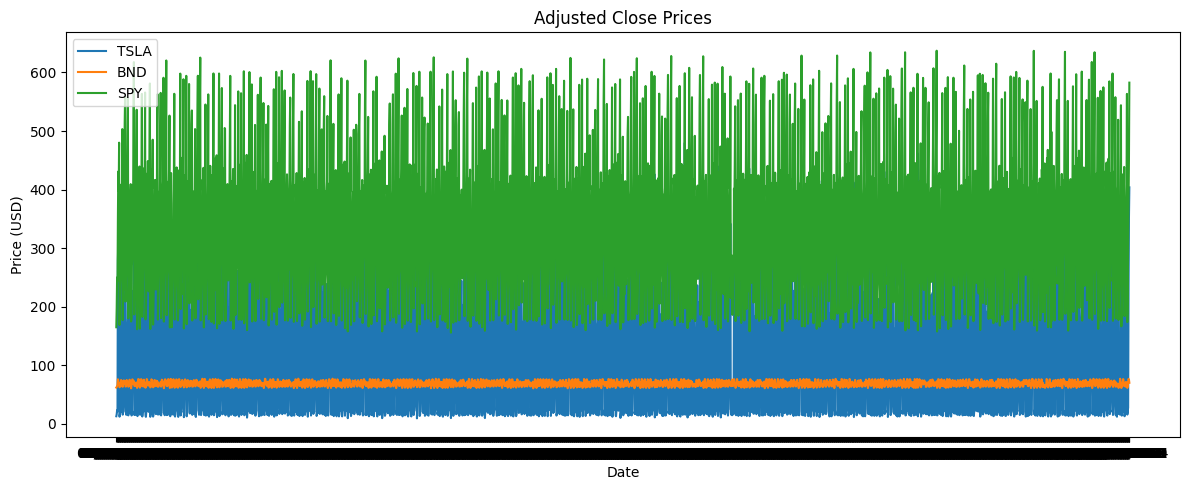

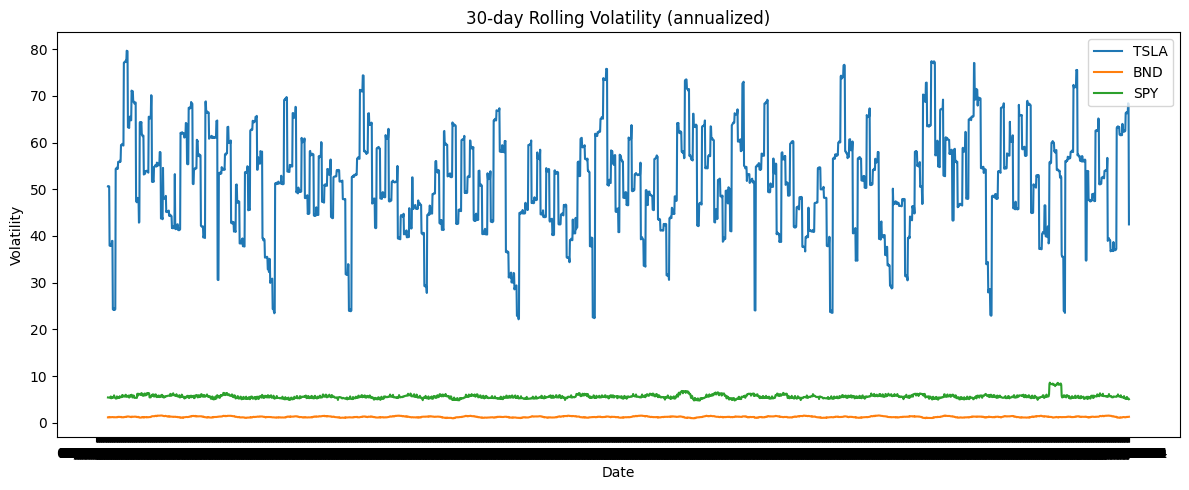

In [15]:


# Plot adjusted close
plt.figure(figsize=(12,5))
for t in TICKERS:
    plt.plot(prices_df.index, prices_df[t], label=t)
plt.title("Adjusted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

# Rolling volatility (30 trading days)
window = 30
rolling_vol = returns_df.rolling(window=window).std() * (252**0.5)  # annualized vol approx
plt.figure(figsize=(12,5))
for t in TICKERS:
    plt.plot(rolling_vol.index, rolling_vol[t], label=t)
plt.title(f"{window}-day Rolling Volatility (annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import json
manifest = {
    "tickers": TICKERS,
    "start_date": START,
    "end_date": END,
    "raw_files": {t: str((RAW_DIR / f"{t}.csv").resolve()) for t in TICKERS},
    "processed_files": {
        "prices_adj": str(Path("../data/processed/prices_adj.csv").resolve()),
        "returns_daily": str(Path("../data/processed/returns_daily.csv").resolve())
    }
}
with open("../data/manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)
print("Wrote data/manifest.json")


Wrote data/manifest.json
